In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import cupy as cp
from torch.utils.data import DataLoader, TensorDataset

cp.cuda.Device(0).use()
print(f"Usando: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode('utf-8')}")

sys.path.append(os.path.abspath(os.path.join('..')))

from models.utils import train_val_test_split, grid_search_and_update, init_hparams_csv, sweep_and_update, load_hparams_csv, plot_history
from models.neural_net import NeuralNetwork
from models.constants import *
from models.torch_model import train_best_model_from_csv, train_architecture_set, to_tensor, train_model, evaluate_metrics, PyTorchModel


Usando: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
X_images = np.load("../data/X_images.npy ")
X_images = X_images / NORMALIZATION_FACTOR

y_images = np.load("../data/y_images.npy ")

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_images, y_images)

X_train = cp.asarray(X_train)
y_train = cp.asarray(y_train)
X_val = cp.asarray(X_val)
y_val = cp.asarray(y_val)
X_test = cp.asarray(X_test)
y_test = cp.asarray(y_test)

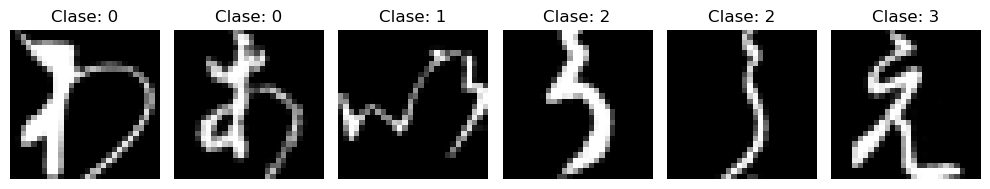

In [24]:
fig, axes = plt.subplots(1, 6, figsize=(10, 4))

for i in range(6):
    img = X_images[50 * i].reshape(28, 28)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Clase: {y_images[50 * i]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


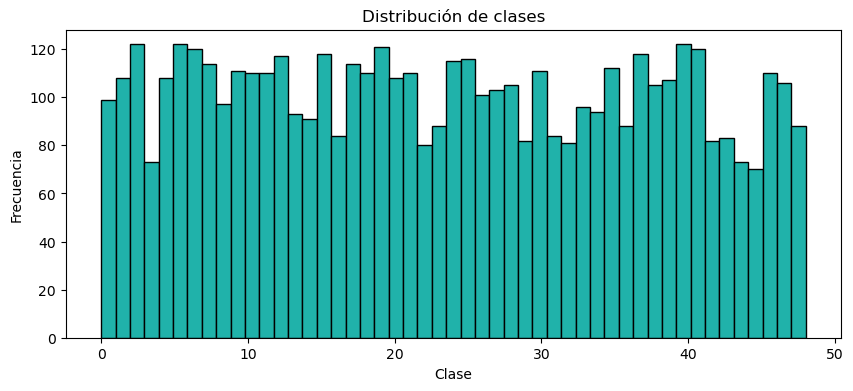

In [45]:
plt.figure(figsize=(10, 4))
_ = plt.hist(y_images, bins=49, color="lightseagreen", edgecolor="black")
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

### M0

In [46]:
M0 = NeuralNetwork(layer_sizes=[IMAGE_SIZE, 100, 80, NUM_CLASSES])

history = M0.train(
    X_train, y_train,
    X_val, y_val,
)

Epoch 4109 - Loss: 0.8114 - Acc: 0.8109 - ValLoss: 1.7063 - ValAcc: 0.5827:  82%|████████▏ | 4109/5000 [01:15<00:16, 54.40it/s]


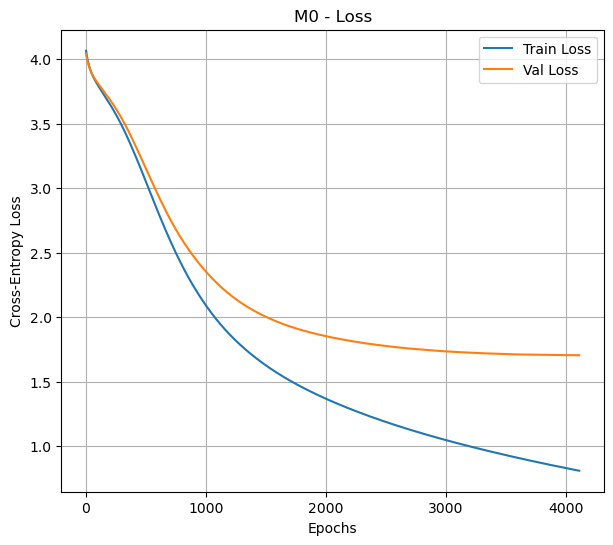

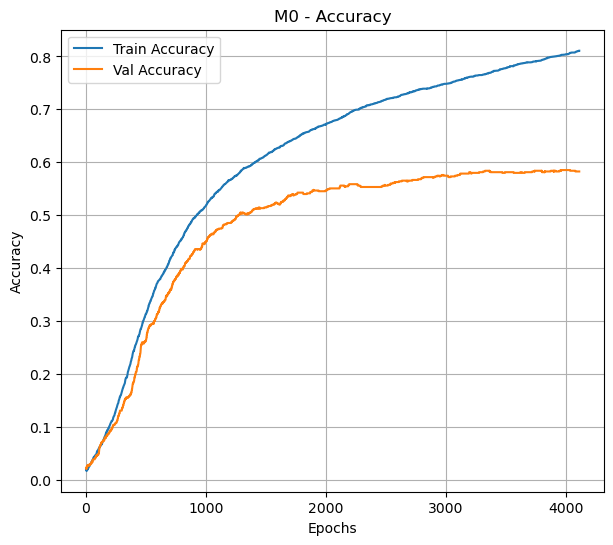

In [49]:
plot_history(history, "M0")

Train Accuracy: 0.8097
Train Cross-Entropy Loss: 0.8147


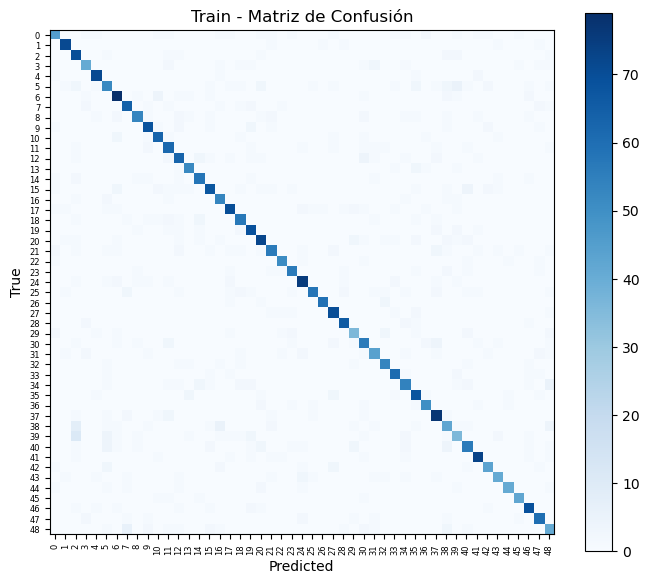

Validation Accuracy: 0.5827
Validation Cross-Entropy Loss: 1.7063


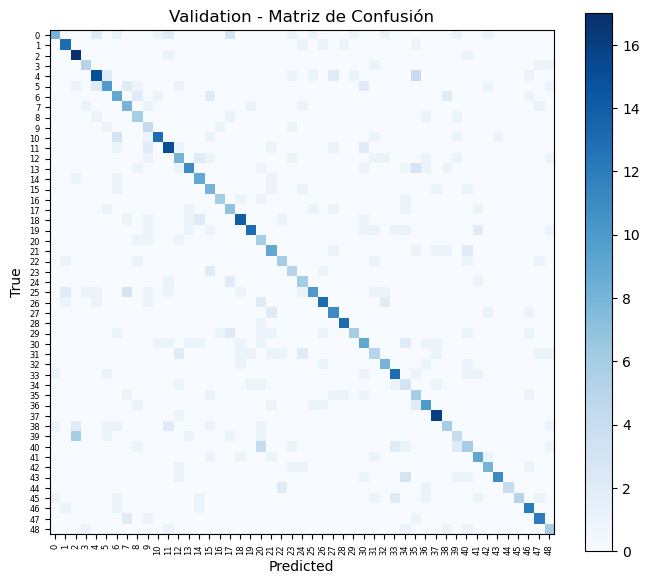

In [ ]:
M0.evaluate_metrics(X_train, y_train, title_prefix="Train")
M0.evaluate_metrics(X_val, y_val, title_prefix="Validation")

### M1

In [20]:
init_hparams_csv(HYPERPARAMS_FILE)

Hiperparámetros por defecto guardados en: hparams.csv


In [10]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="early_stopping",
    values=[True, False]
)


Probing early_stopping = True


Epoch 687 - Loss: 0.6519 - Acc: 0.8868 - ValLoss: 1.5205 - ValAcc: 0.6293:  14%|█▎        | 687/5000 [01:35<09:58,  7.21it/s]


early_stopping = True → val_loss = 1.5167

Probing early_stopping = False


Epoch 5000 - Loss: 0.2764 - Acc: 0.9885 - ValLoss: 1.5825 - ValAcc: 0.6293: 100%|██████████| 5000/5000 [11:48<00:00,  7.06it/s]

early_stopping = False → val_loss = 1.5825

Actualizado 'early_stopping' a: True

Mejor early_stopping: True con val_loss = 1.5167


In [11]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="patience",
    values=[10, 20, 30, 40, 50]
)


Probing patience = 10


Epoch 518 - Loss: 0.7325 - Acc: 0.8603 - ValLoss: 1.5429 - ValAcc: 0.6187:  10%|█         | 518/5000 [01:11<10:21,  7.22it/s]


patience = 10 → val_loss = 1.5427

Probing patience = 20


Epoch 687 - Loss: 0.6519 - Acc: 0.8868 - ValLoss: 1.5205 - ValAcc: 0.6293:  14%|█▎        | 687/5000 [01:35<09:56,  7.23it/s]


patience = 20 → val_loss = 1.5167

Probing patience = 30


Epoch 796 - Loss: 0.6128 - Acc: 0.9035 - ValLoss: 1.5078 - ValAcc: 0.6307:  16%|█▌        | 796/5000 [01:50<09:43,  7.21it/s]


patience = 30 → val_loss = 1.5070

Probing patience = 40


Epoch 948 - Loss: 0.5740 - Acc: 0.9123 - ValLoss: 1.4964 - ValAcc: 0.6480:  19%|█▉        | 948/5000 [02:13<09:32,  7.08it/s]


patience = 40 → val_loss = 1.4971

Probing patience = 50


Epoch 958 - Loss: 0.5719 - Acc: 0.9117 - ValLoss: 1.4983 - ValAcc: 0.6520:  19%|█▉        | 958/5000 [02:16<09:36,  7.01it/s]

patience = 50 → val_loss = 1.4988

Actualizado 'patience' a: 40

Mejor patience: 40 con val_loss = 1.4971


In [ ]:
architectures = [
    (IMAGE_SIZE, 64, NUM_CLASSES),
    (IMAGE_SIZE, 128, NUM_CLASSES),
    (IMAGE_SIZE, 256, NUM_CLASSES),

    (IMAGE_SIZE, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, NUM_CLASSES),

    (IMAGE_SIZE, 256, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 768, 384, 192, NUM_CLASSES),
]

sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="layer_sizes",
    values=architectures
)

Sweep layer_sizes: 100%|██████████| 9/9 [21:32<00:00, 143.65s/it]

Actualizado 'layer_sizes' a: (784, 768, 384, 192, 49)
Mejor layer_sizes: (784, 768, 384, 192, 49) con val_loss = 1.5998


In [22]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="batch_size",
    values=[None, 512, 256, 128, 64, 32, 16]
)

Sweep batch_size: 100%|██████████| 7/7 [21:09<00:00, 181.30s/it]   

Actualizado 'batch_size' a: 512
Mejor batch_size: 512 con val_loss = 1.5978


In [23]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="lr",
    values=[0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001]
)

Sweep lr: 100%|██████████| 6/6 [32:24<00:00, 324.03s/it]

Actualizado 'lr' a: 0.01
Mejor lr: 0.01 con val_loss = 1.5978


In [22]:
param_grid = {
    "use_adam": [True, False],
    "beta1": [0.9, 0.95, 0.99],
    "beta2": [0.99, 0.999, 0.9999]
}

grid_search_and_update(
    X_train, y_train, X_val, y_val,
    param_grid=param_grid,
)

Grid Search: 100%|██████████| 18/18 [16:15<00:00, 54.19s/it]

Actualizado 'use_adam' a: False
Actualizado 'beta1' a: 0.9
Actualizado 'beta2' a: 0.99
Grid Search terminado. Mejor val_loss = 1.5167


In [18]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="l2_lambda",
    values=[1e-5, 1e-4, 1e-3, 1e-2, 0.0]
)


Probing l2_lambda = 0.0


Epoch 303 - Loss: 0.5579 - Acc: 0.8977 - ValLoss: 1.6012 - ValAcc: 0.6187:   6%|▌         | 303/5000 [00:41<10:50,  7.23it/s]


l2_lambda = 0.0 → val_loss = 1.5978

Probing l2_lambda = 1e-05


Epoch 303 - Loss: 0.5582 - Acc: 0.8974 - ValLoss: 1.6011 - ValAcc: 0.6173:   6%|▌         | 303/5000 [00:41<10:50,  7.22it/s]


l2_lambda = 1e-05 → val_loss = 1.5978

Probing l2_lambda = 0.0001


Epoch 303 - Loss: 0.5616 - Acc: 0.8974 - ValLoss: 1.6000 - ValAcc: 0.6187:   6%|▌         | 303/5000 [00:42<10:59,  7.12it/s]


l2_lambda = 0.0001 → val_loss = 1.5967

Probing l2_lambda = 0.001


Epoch 352 - Loss: 0.4871 - Acc: 0.9192 - ValLoss: 1.5879 - ValAcc: 0.6187:   7%|▋         | 352/5000 [00:49<10:57,  7.07it/s]


l2_lambda = 0.001 → val_loss = 1.5895

Probing l2_lambda = 0.01


Epoch 687 - Loss: 0.6519 - Acc: 0.8868 - ValLoss: 1.5205 - ValAcc: 0.6293:  14%|█▎        | 687/5000 [01:37<10:10,  7.06it/s]

l2_lambda = 0.01 → val_loss = 1.5167
Actualizado 'l2_lambda' a: 0.01
Mejor l2_lambda: 0.01 con val_loss = 1.5167


In [19]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="dropout_rate",
    values=[0.0, 0.1, 0.2, 0.3, 0.5]
)


Probing dropout_rate = 0.0


Epoch 687 - Loss: 0.6519 - Acc: 0.8868 - ValLoss: 1.5205 - ValAcc: 0.6293:  14%|█▎        | 687/5000 [01:36<10:03,  7.14it/s]


dropout_rate = 0.0 → val_loss = 1.5167

Probing dropout_rate = 0.1


Epoch 183 - Loss: 1.7992 - Acc: 0.5220 - ValLoss: 2.3046 - ValAcc: 0.4440:   4%|▎         | 183/5000 [00:27<12:05,  6.64it/s]


dropout_rate = 0.1 → val_loss = 2.2851

Probing dropout_rate = 0.2


Epoch 116 - Loss: 2.8614 - Acc: 0.3148 - ValLoss: 3.2332 - ValAcc: 0.2667:   2%|▏         | 116/5000 [00:17<12:08,  6.71it/s]


dropout_rate = 0.2 → val_loss = 3.1078

Probing dropout_rate = 0.3


Epoch 98 - Loss: 3.4525 - Acc: 0.1871 - ValLoss: 3.6811 - ValAcc: 0.1653:   2%|▏         | 98/5000 [00:14<12:11,  6.70it/s]


dropout_rate = 0.3 → val_loss = 3.7120

Probing dropout_rate = 0.5


Epoch 80 - Loss: 4.0889 - Acc: 0.0745 - ValLoss: 4.1152 - ValAcc: 0.0613:   2%|▏         | 80/5000 [00:11<12:13,  6.71it/s]

dropout_rate = 0.5 → val_loss = 4.1975
Actualizado 'dropout_rate' a: 0.0
Mejor dropout_rate: 0.0 con val_loss = 1.5167


In [27]:
param_grid = {
    "scheduler_type": ["linear", "exponential", None],
    "final_lr": [0.0001, 0.00005]
}

grid_search_and_update(
    X_train, y_train, X_val, y_val,
    param_grid=param_grid,
)

Grid Search: 100%|██████████| 6/6 [09:35<00:00, 95.87s/it]

Actualizado 'scheduler_type' a: None
Actualizado 'final_lr' a: 0.0001
Grid Search terminado. Mejor val_loss = 1.5167


In [28]:
sweep_and_update(
    X_train, y_train, X_val, y_val,
    param_name="use_batchnorm",
    values=[True, False],
    csv_path="hparams.csv",
    metric="val_loss"
)

Sweep use_batchnorm: 100%|██████████| 2/2 [01:56<00:00, 58.04s/it]

Actualizado 'use_batchnorm' a: False
Mejor use_batchnorm: False con val_loss = 1.5167


In [47]:
best_params = load_hparams_csv("hparams.csv")

M1 = NeuralNetwork(
    layer_sizes=best_params["layer_sizes"],
    use_batchnorm=best_params["use_batchnorm"],
    dropout_rate=best_params["dropout_rate"],
    use_adam=best_params["use_adam"],
    beta1=best_params["beta1"],
    beta2=best_params["beta2"],
    eps=1e-8,
    l2_lambda=best_params["l2_lambda"],
    scheduler_type=best_params["scheduler_type"],
    final_lr=best_params["final_lr"],
    seed=RANDOM_SEED
)

M1_history = M1.train(
    X_train, y_train,
    X_val, y_val,
    lr=best_params["lr"],
    final_lr=best_params["final_lr"],
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    early_stopping=best_params["early_stopping"],
    patience=best_params["patience"],
    show_progress=True
)

Epoch 948 - Loss: 0.5740 - Acc: 0.9123 - ValLoss: 1.4964 - ValAcc: 0.6480:  19%|█▉        | 948/5000 [02:24<10:19,  6.54it/s]


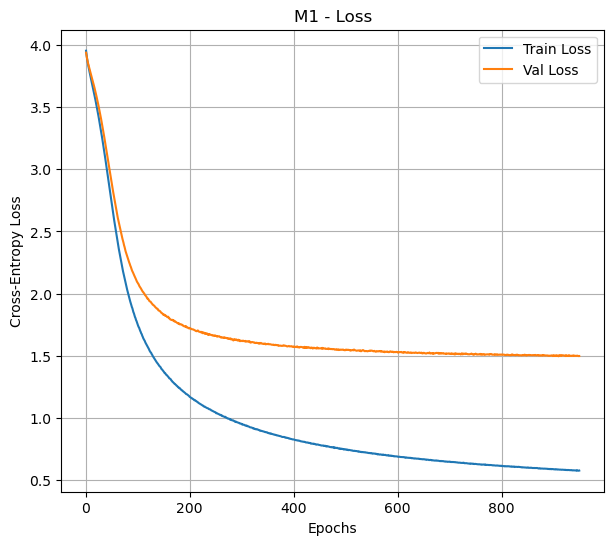

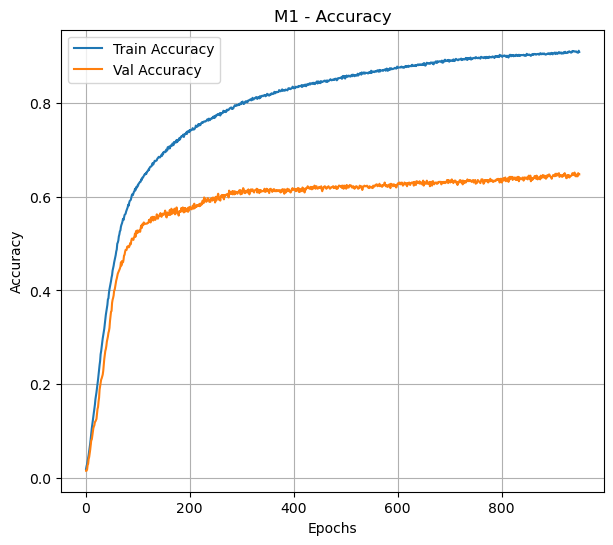

In [59]:
plot_history(M1_history, "M1")

Train Accuracy: 0.9106
Train Cross-Entropy Loss: 0.5804


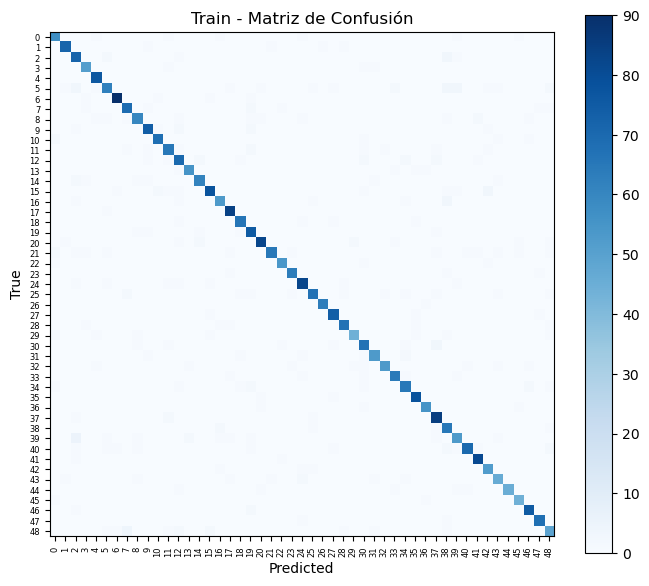

Validation Accuracy: 0.6467
Validation Cross-Entropy Loss: 1.4954


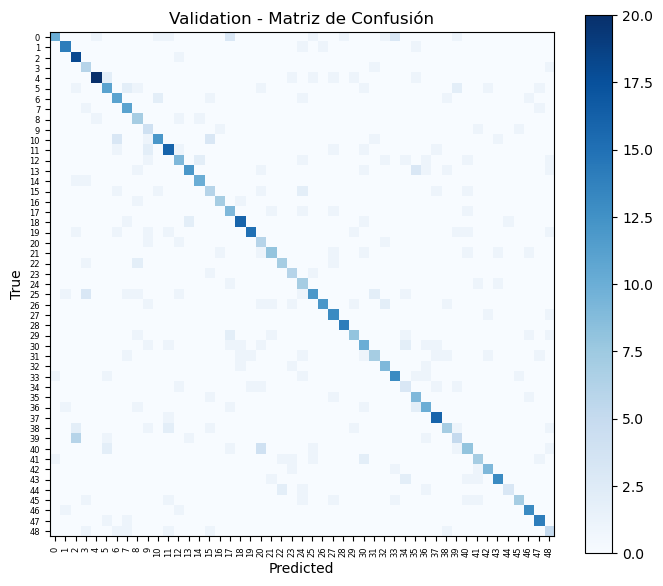

In [60]:
M1.evaluate_metrics(X_train, y_train, title_prefix="Train")
M1.evaluate_metrics(X_val, y_val, title_prefix="Validation")

### M2

In [62]:
M2, M2_history= train_best_model_from_csv(X_train, y_train, X_val, y_val)

Epoch 2405 - TrainLoss: 1.0854, TrainAcc: 0.7229, ValLoss: 1.8707, ValAcc: 0.5213:  48%|▍| 2404/5000

Early stopping at epoch 2405


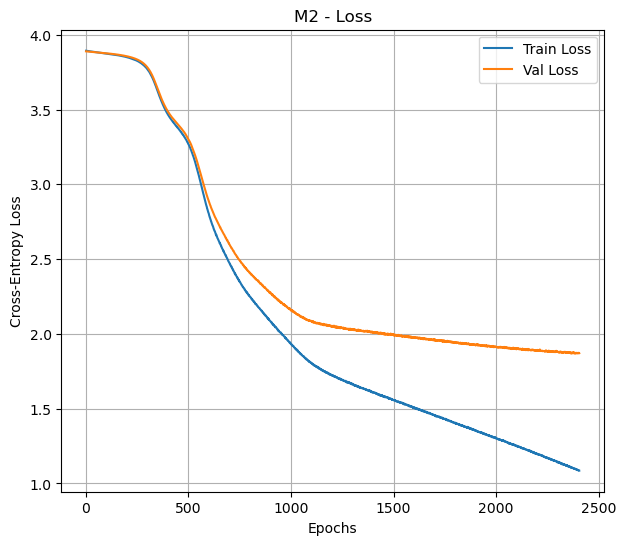

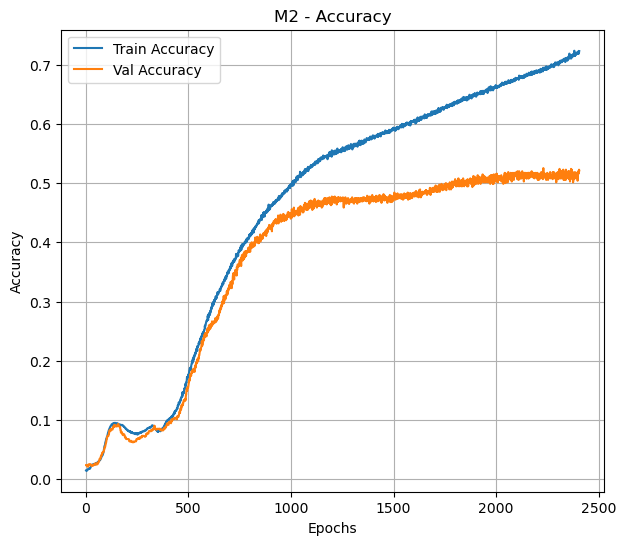

In [63]:
plot_history(M2_history, "M2")

Train Accuracy: 0.7240
Train Cross-Entropy Loss: 1.0809


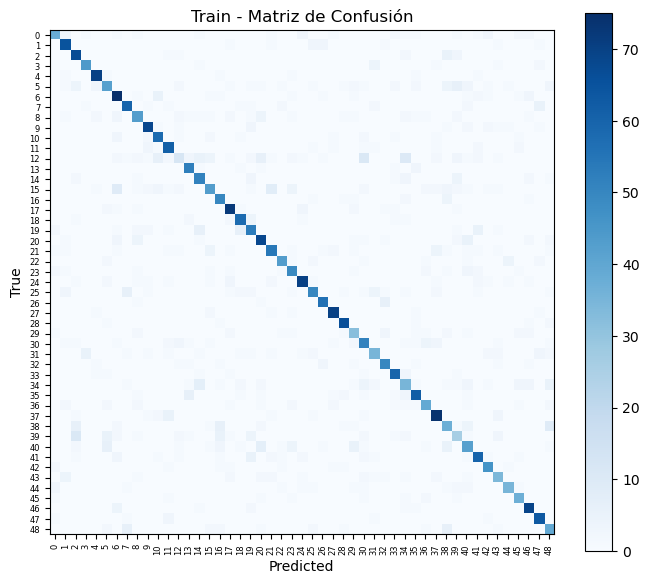

Validation Accuracy: 0.5213
Validation Cross-Entropy Loss: 1.8780


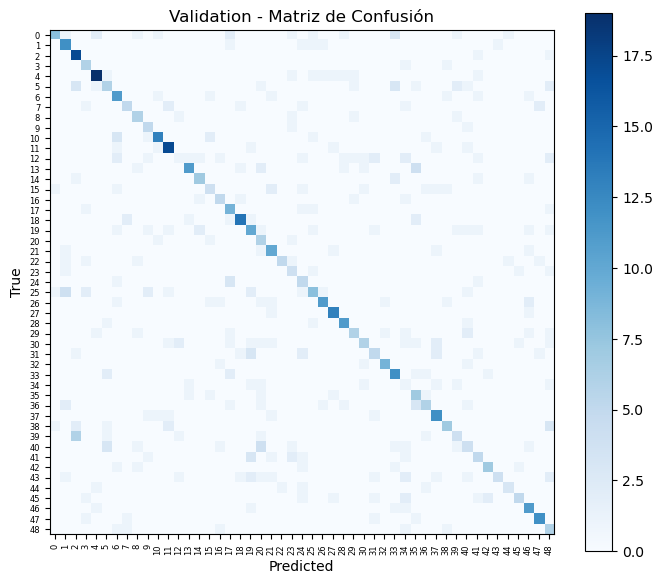

In [64]:
evaluate_metrics(
    M2,
    X_train, y_train,
    title_prefix="Train"
)

evaluate_metrics(
    M2,
    X_val, y_val,
    title_prefix="Validation"
)

### M3

In [52]:
architectures = [
    (IMAGE_SIZE, 64, NUM_CLASSES),
    (IMAGE_SIZE, 128, NUM_CLASSES),
    (IMAGE_SIZE, 256, NUM_CLASSES),

    (IMAGE_SIZE, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, NUM_CLASSES),

    (IMAGE_SIZE, 256, 128, 64, NUM_CLASSES),
    (IMAGE_SIZE, 512, 256, 128, NUM_CLASSES),
    (IMAGE_SIZE, 768, 384, 192, NUM_CLASSES),
]

m3_results = train_architecture_set(X_train, y_train, X_val, y_val, architectures)
best_architecture_m3 = m3_results[0][0]
M3 = m3_results[0][2]
M3_history = m3_results[0][3]

print(f"Mejor arquitectura M3: {best_architecture_m3}")



Entrenando arquitectura: (784, 256, 49)


Epoch 5000 - TrainLoss: 0.9113, TrainAcc: 0.8289, ValLoss: 1.5380, ValAcc: 0.6240: 100%|█| 5000/5000

Val loss: 1.5380
Mejor arquitectura M3: (784, 256, 49)


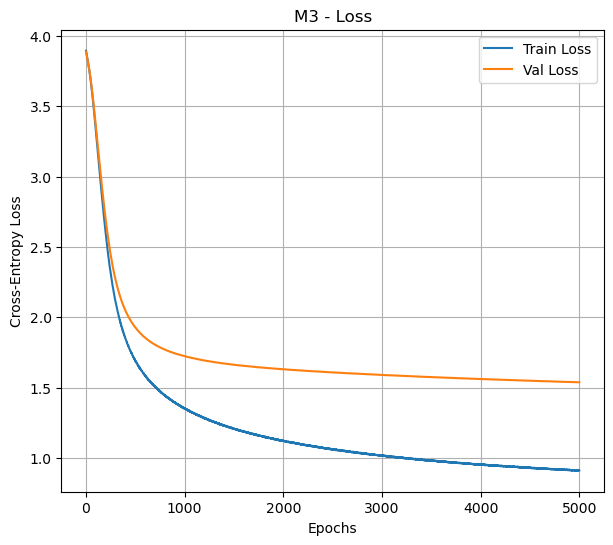

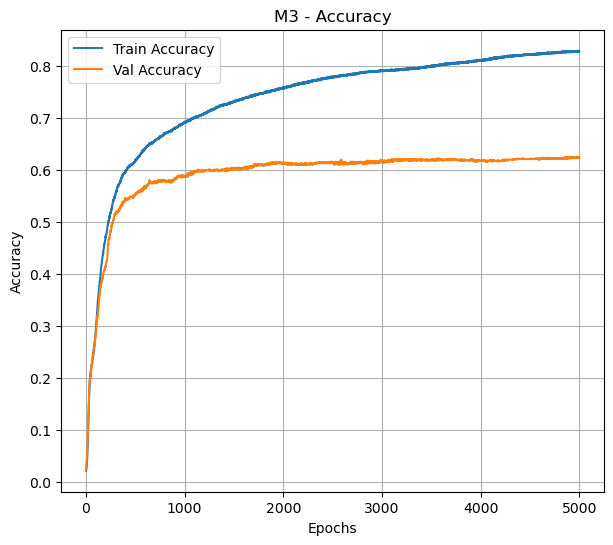

In [53]:
plot_history(M3_history, "M3")

Train Accuracy: 0.8286
Train Cross-Entropy Loss: 0.9092


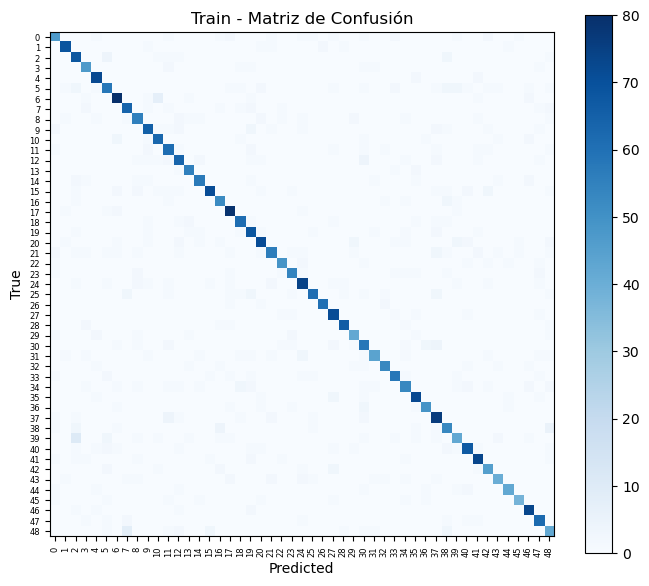

Validation Accuracy: 0.6240
Validation Cross-Entropy Loss: 1.5537


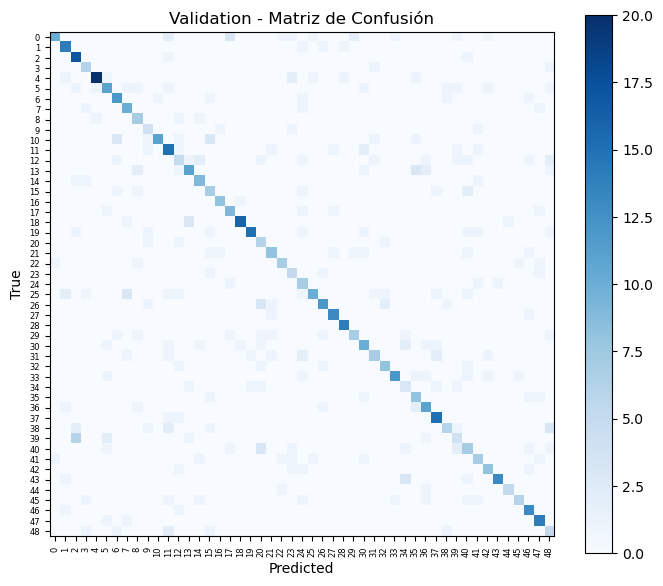

In [54]:
evaluate_metrics(
    M3,
    X_train, y_train,
    title_prefix="Train",
)

evaluate_metrics(
    M3,
    X_val, y_val,
    title_prefix="Validation",
)

In [26]:
X_train_t, y_train_t = to_tensor(cp.asnumpy(X_train), cp.asnumpy(y_train))
X_val_t, y_val_t = to_tensor(cp.asnumpy(X_val), cp.asnumpy(y_val))

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=512)

overfit_architecture = (IMAGE_SIZE, 2048, 2048, 1024, 512, 256, NUM_CLASSES)

M4 = PyTorchModel(
    layer_sizes=overfit_architecture,
    use_batchnorm=False,
    dropout_rate=0.0
)

M4, M4_history = train_model(
    M4, train_loader, val_loader,
    epochs=5000,
    lr=0.001,
    weight_decay=0.0,
    use_adam=False,
    beta1=0.9,
    beta2=0.999,
    scheduler_type=None,
    final_lr=None,
    early_stopping=False
)


Epoch 5000 - TrainLoss: 0.0003, TrainAcc: 1.0000, ValLoss: 9.1692, ValAcc: 0.4293: 100%|█| 5000/5000


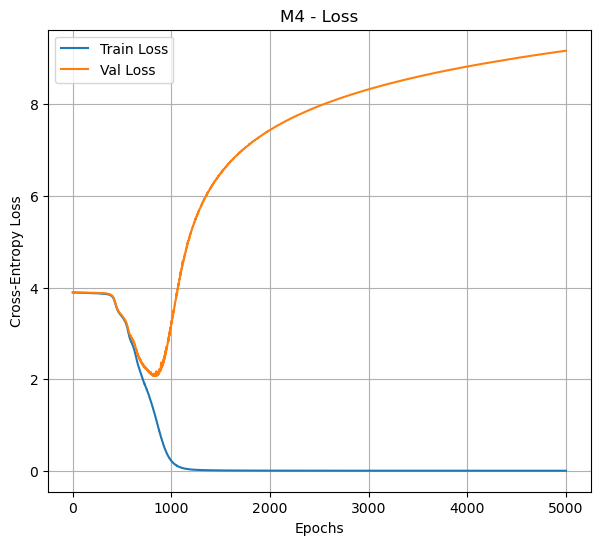

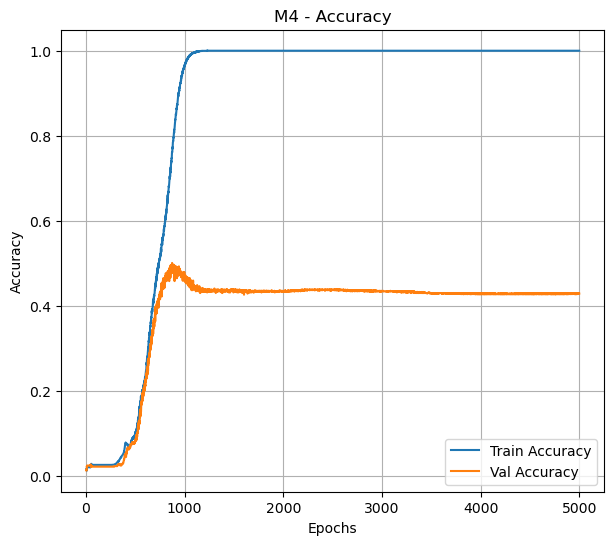

In [55]:
plot_history(M4_history, "M4")

Train Accuracy: 1.0000
Train Cross-Entropy Loss: 0.0003


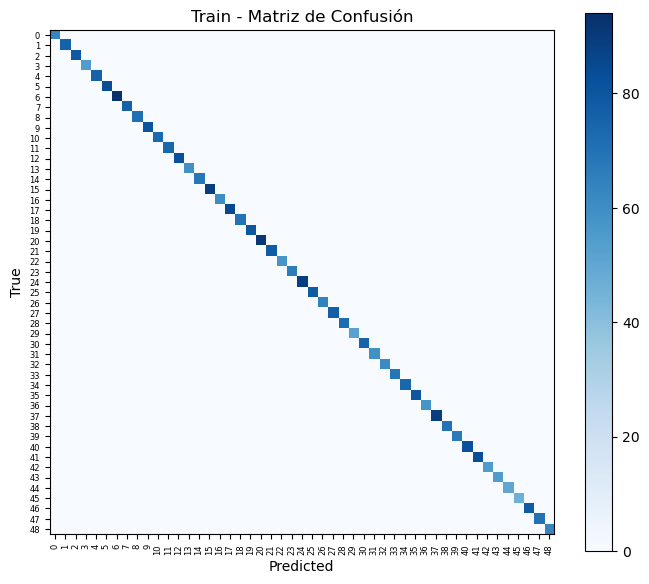

Validation Accuracy: 0.4293
Validation Cross-Entropy Loss: 9.4385


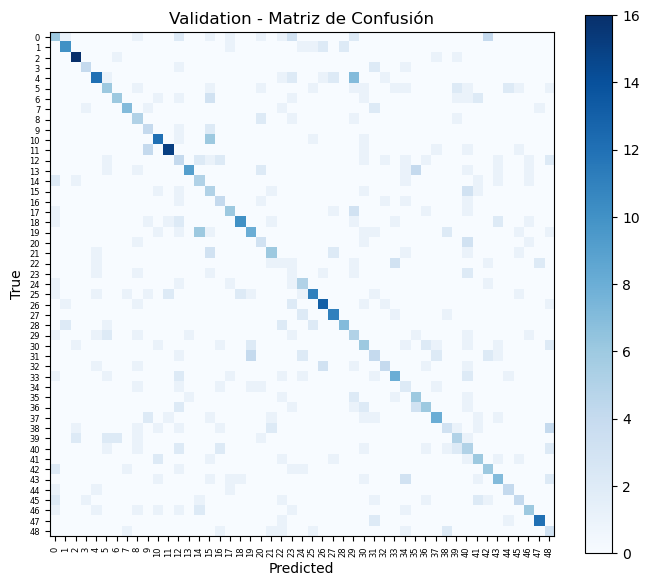

In [58]:
evaluate_metrics(
    M4,
    X_train, y_train,
    title_prefix="Train",
)

evaluate_metrics(
    M4,
    X_val, y_val,
    title_prefix="Validation",
)

M0 - Test Accuracy: 0.5800
M0 - Test Cross-Entropy Loss: 1.7032


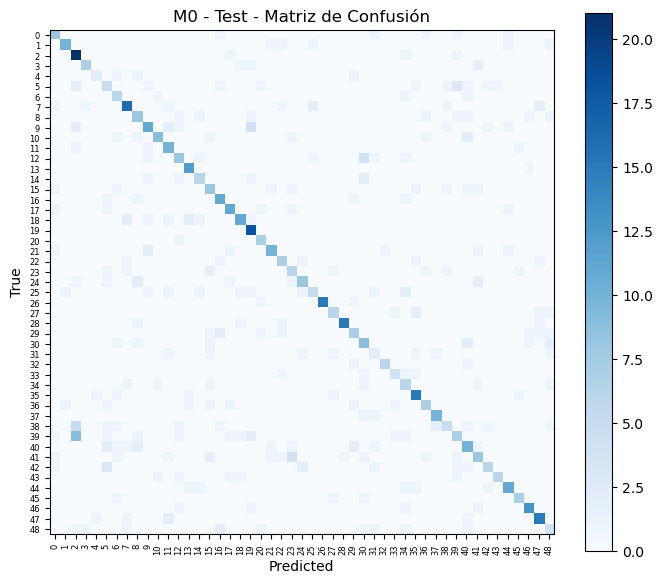

M1 - Test Accuracy: 0.6427
M1 - Test Cross-Entropy Loss: 1.4578


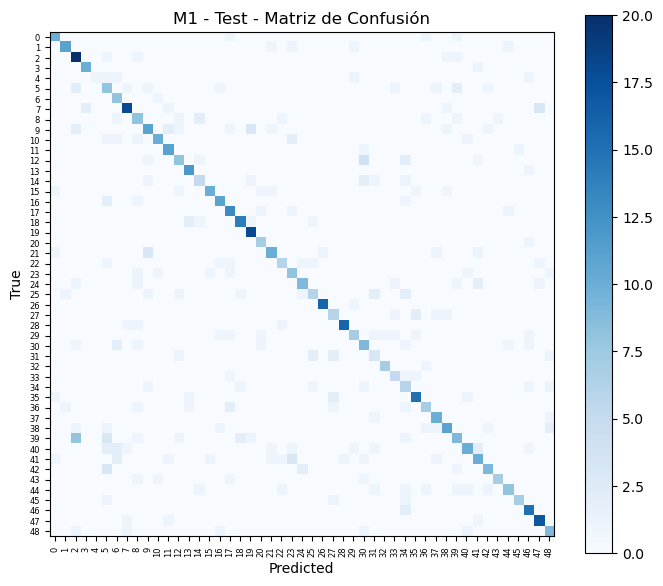

M2 - Test Accuracy: 0.5253
M2 - Test Cross-Entropy Loss: 1.9369


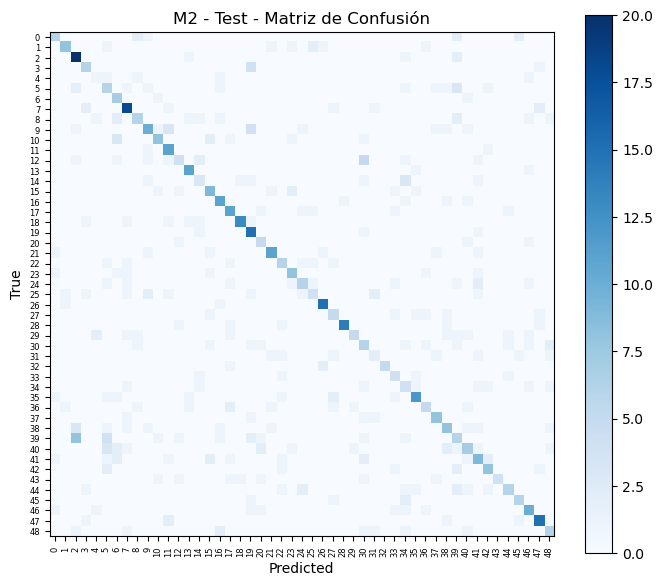

M3 - Test Accuracy: 0.6387
M3 - Test Cross-Entropy Loss: 1.5455


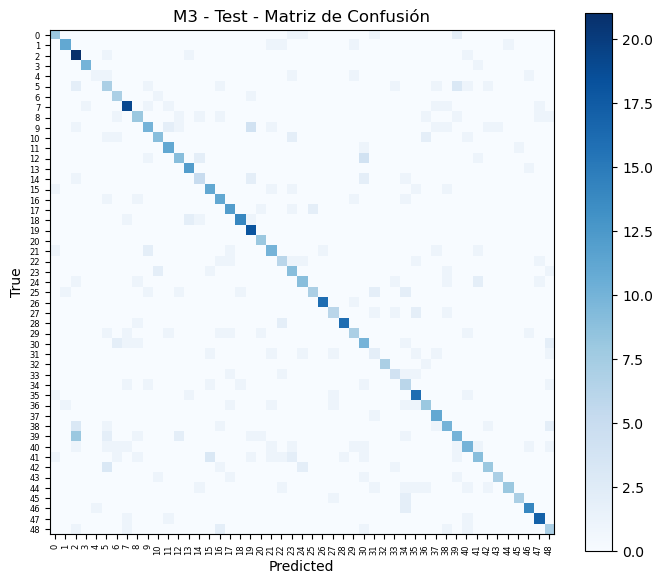

M4 - Test Accuracy: 0.4413
M4 - Test Cross-Entropy Loss: 10.1525


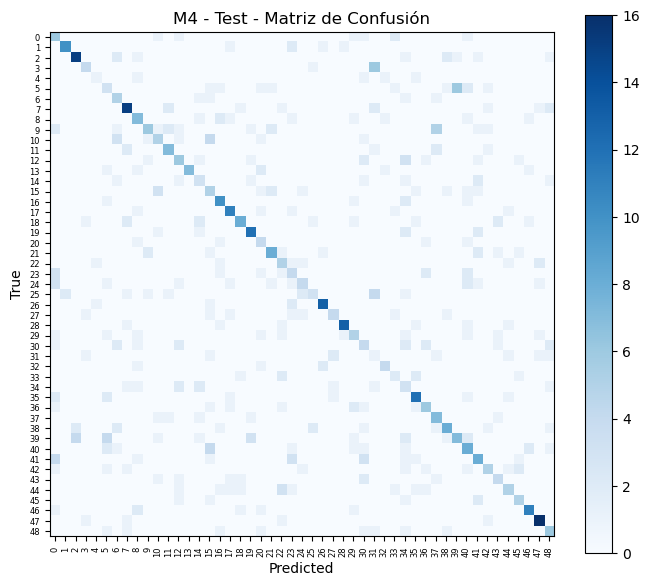

In [56]:
M0.evaluate_metrics(X_test, y_test, title_prefix="M0 - Test")
M1.evaluate_metrics(X_test, y_test, title_prefix="M1 - Test")
evaluate_metrics(M2, X_test, y_test, title_prefix="M2 - Test")
evaluate_metrics(M3, X_test, y_test, title_prefix="M3 - Test")
evaluate_metrics(M4, X_test, y_test, title_prefix="M4 - Test")

In [67]:
X_comp = np.load("../data/X_COMP.npy")
X_comp = X_comp / NORMALIZATION_FACTOR

X_comp = cp.asarray(X_comp)

y_proba = M1.predict_proba(X_comp)

column_names = [f"Clase_{i}" for i in range(49)]
df_predicciones = pd.DataFrame(y_proba.get(), columns=column_names)

df_predicciones.to_csv("Nomberg_Ilan_predicciones.csv", index=False)
print("Archivo guardado como Nomberg_Ilan_predicciones.csv")

Archivo guardado como Nomberg_Ilan_predicciones.csv
